In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [78]:
data1 = pd.read_csv('databaru_eda.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [79]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1826 non-null   object 
 1   Total                1826 non-null   int64  
 2   Influneza A          1826 non-null   int64  
 3   Influneza B          1826 non-null   int64  
 4   Male                 1826 non-null   int64  
 5   Female               1826 non-null   int64  
 6   0–5 months           1826 non-null   int64  
 7   6–11 months          1826 non-null   int64  
 8   1 year               1826 non-null   int64  
 9   2 years              1826 non-null   int64  
 10  3 years              1826 non-null   int64  
 11  4 years              1826 non-null   int64  
 12  5 years              1826 non-null   int64  
 13  6 years              1826 non-null   int64  
 14  7 years              1826 non-null   int64  
 15  8 years              1826 non-null   i

In [80]:
drop_cols = [
    "Influneza A", "Influneza B","Male", "Female", "0–5 months", "6–11 months", "1 year", "2 years", "3 years", "4 years", "5 years",
    "6 years", "7 years", "8 years", "9 years",
    "10–14 years", "15–19 years", "20–29 years",
    "30–39 years", "40–49 years", "50–59 years",
    "60–69 years", "70–79 years", "80 years and over",
    "Temperature", "Minimum Temperature", "Maximum Temperature",
    "Year", "Month", "Day"
]

df_clean = data1.drop(columns=[c for c in drop_cols if c in data1.columns])
df_clean["Date"] = pd.to_datetime(
    df_clean["Date"],
    format="%Y/%m/%d"
)
df_clean["Year"] = df_clean["Date"].dt.year

print(df_clean.columns.tolist())

['Date', 'Total', 'Relative humidity', 'Wind speed', 'Rainfall', 'Sunshine duration', 'Vapour pressure', 'Year']


In [81]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1826 non-null   datetime64[ns]
 1   Total              1826 non-null   int64         
 2   Relative humidity  1826 non-null   int64         
 3   Wind speed         1826 non-null   float64       
 4   Rainfall           1036 non-null   float64       
 5   Sunshine duration  1826 non-null   object        
 6   Vapour pressure    1826 non-null   float64       
 7   Year               1826 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(1)
memory usage: 107.1+ KB


In [82]:
df_clean.isnull().sum()

Date                   0
Total                  0
Relative humidity      0
Wind speed             0
Rainfall             790
Sunshine duration      0
Vapour pressure        0
Year                   0
dtype: int64

In [83]:
ts = data1['Total'].astype(float)
ts = df_clean.set_index("Date")["Total"] 

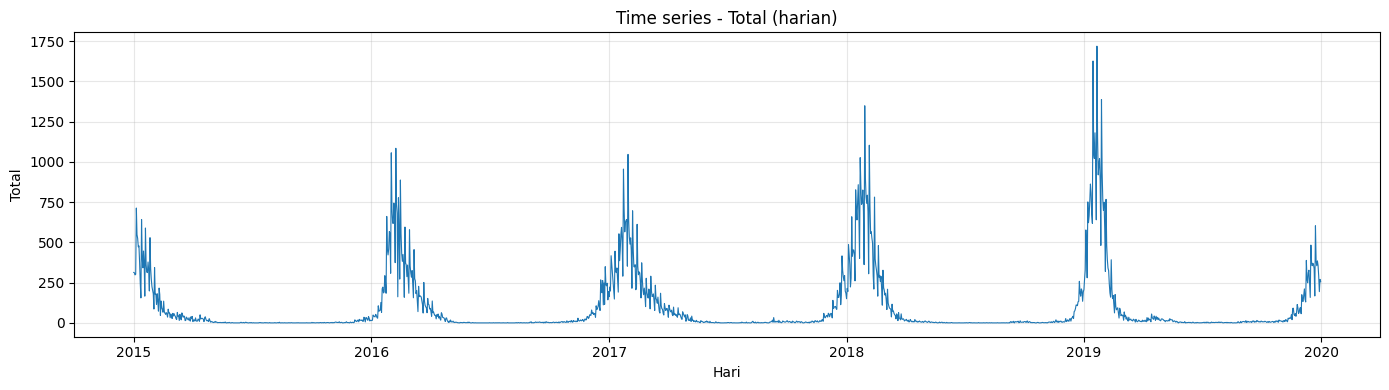

In [84]:
plt.figure(figsize=(14,4))
plt.plot(ts, linewidth=0.8)
plt.title('Time series - Total (harian)')
plt.xlabel('Hari')
plt.ylabel('Total')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

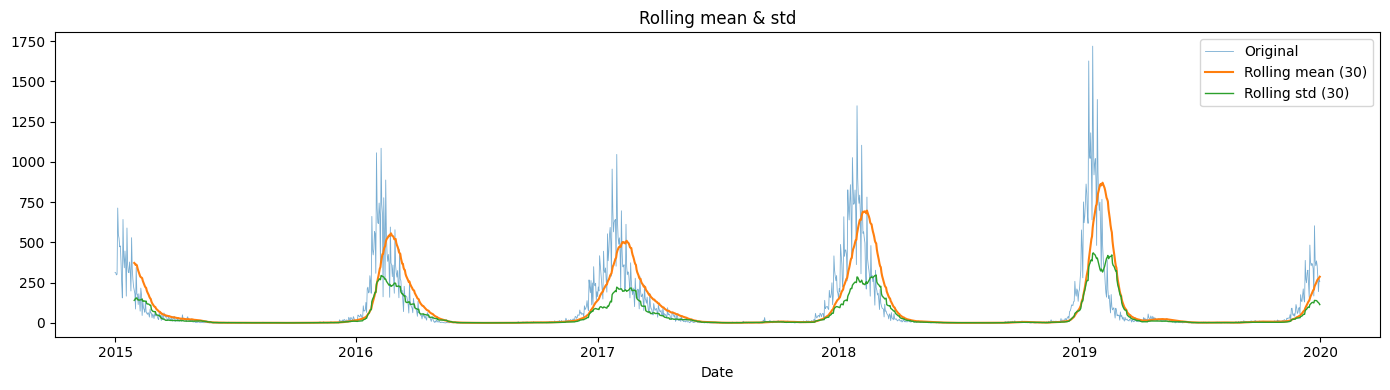

In [85]:
window = 30 
rolling_mean = ts.rolling(window=window).mean()
rolling_std  = ts.rolling(window=window).std()

plt.figure(figsize=(14,4))
plt.plot(ts, label='Original', alpha=0.6, linewidth=0.6)
plt.plot(rolling_mean, label=f'Rolling mean ({window})', linewidth=1.5)
plt.plot(rolling_std, label=f'Rolling std ({window})', linewidth=1.0)
plt.legend()
plt.title('Rolling mean & std')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

C:\Users\MADEYZ\AppData\Local\Temp\ipykernel_17096\769884528.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_month = ts.resample('M').sum()


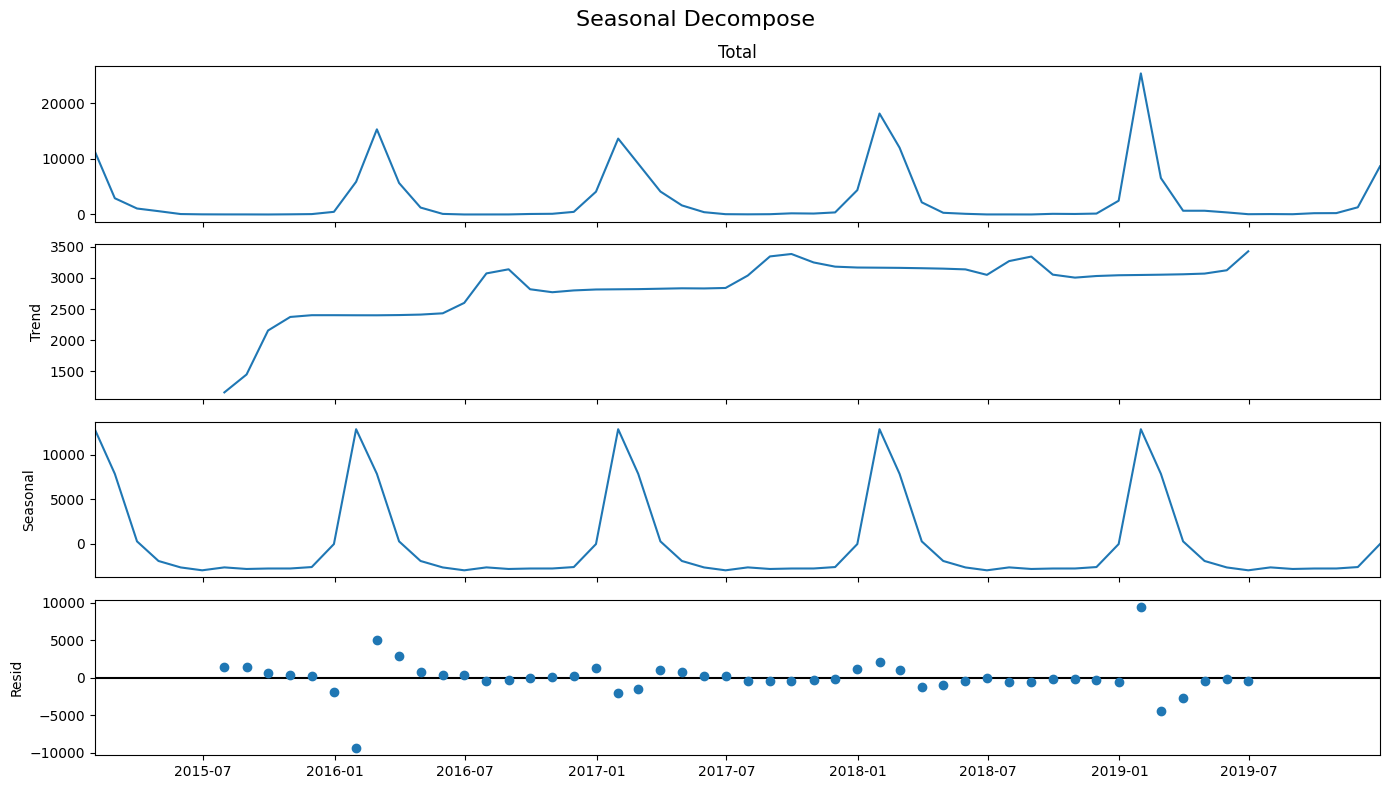

In [86]:
ts_month = ts.resample('M').sum()
freq = None
result = seasonal_decompose(ts_month if len(ts_month)>24 else ts, model='additive', period=12)
plt.rcParams.update({'figure.figsize': (14,8)})
result.plot().suptitle('Seasonal Decompose', fontsize=16)
plt.tight_layout()
plt.show()

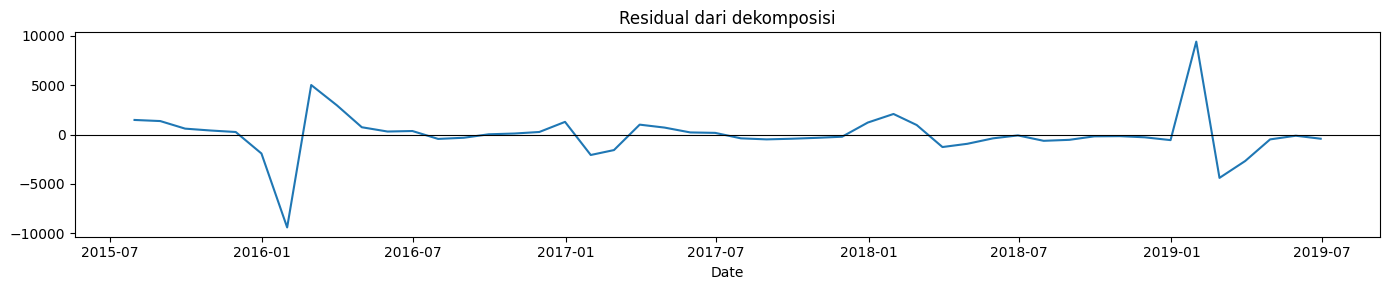

In [87]:
resid = result.resid.dropna()
plt.figure(figsize=(14,3))
plt.plot(resid)
plt.title('Residual dari dekomposisi')
plt.xlabel('Date')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [88]:
adf_result = adfuller(data1['Total'])
adf_result

# output (adf_statistic, p_value, used_lag, n_obs, critical_values, icbest)

(-4.762877162523034,
 6.401272048569019e-05,
 22,
 1803,
 {'1%': -3.4339820768018106,
  '5%': -2.8631443597478143,
  '10%': -2.567624108684946},
 19702.551373257367)

ADF statistic = -4.763

p-value = 0.000064

Keputusan:

0.000064 < 0.05 

-4.763 < -3.434 (CV 1%) 

Keduanya terpenuhi → H₀ DITOLAK (data stationer)

# Arima

<Figure size 1400x500 with 0 Axes>

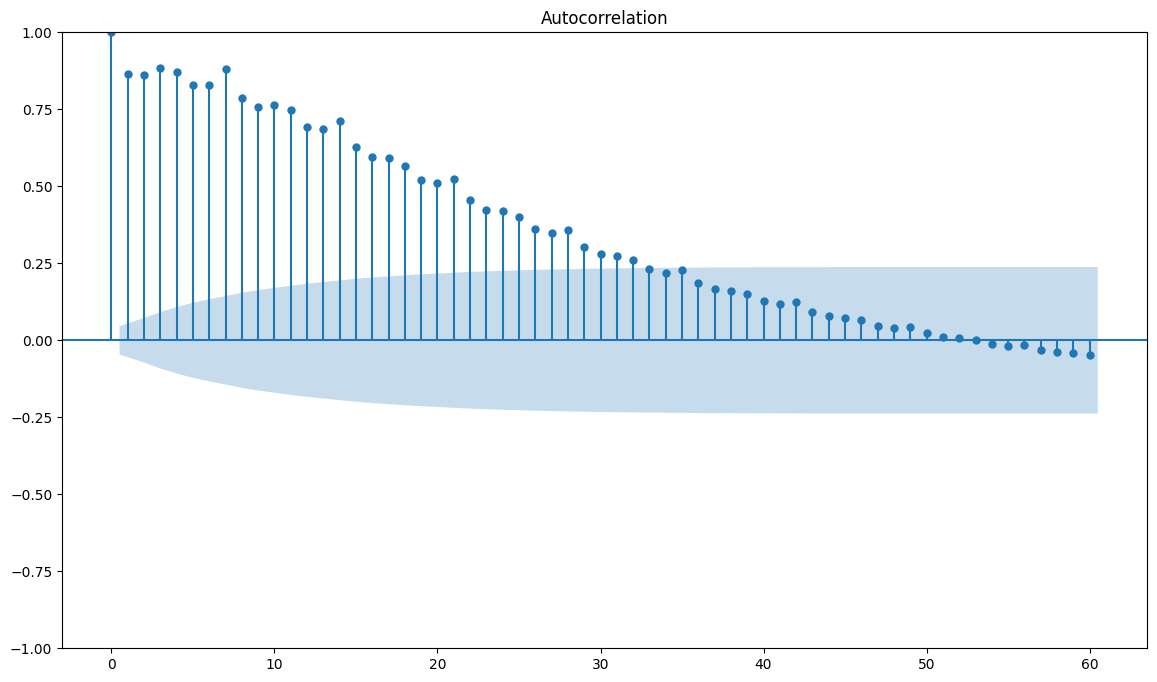

<Figure size 1400x500 with 0 Axes>

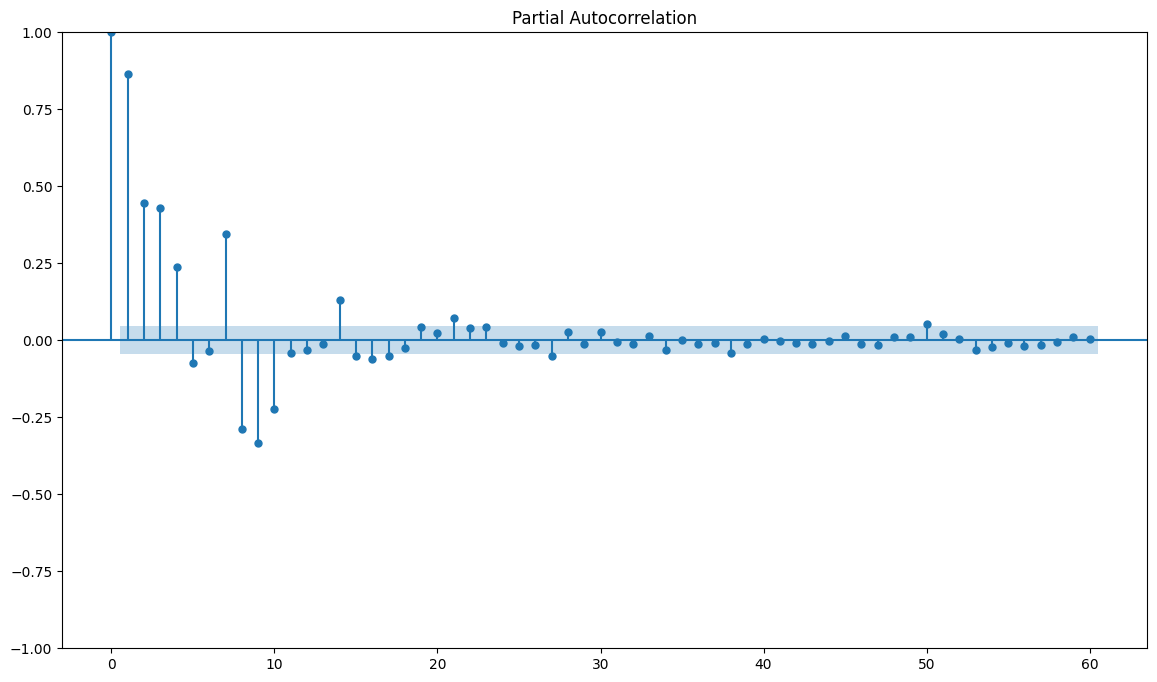

In [89]:
plt.figure(figsize=(14,5))
plot_acf(data1['Total'], lags=60)
plt.show()

plt.figure(figsize=(14,5))
plot_pacf(data1['Total'], lags=60)
plt.show()

Karena data terbukti secara plot adalah data seasonal maka kita lakukan diferencing supaya bisa dilihat kita mengambil lags berapa

In [90]:
ts_diff = ts.diff().dropna()


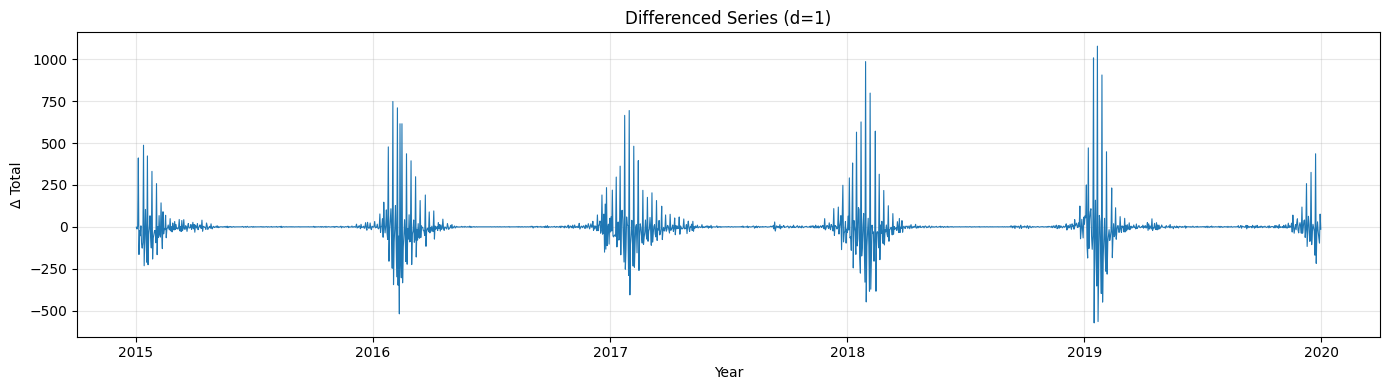

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(ts_diff, linewidth=0.8)
plt.title("Differenced Series (d=1)")
plt.xlabel("Year")
plt.ylabel("Δ Total")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [92]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(ts_diff)

print("ADF Statistic :", adf_result[0])
print("p-value       :", adf_result[1])


ADF Statistic : -9.956454201123192
p-value       : 2.4369563836728616e-17


p-value < 0.05 → tolak H₀ → STASIONER

# Sarima

<Figure size 1400x500 with 0 Axes>

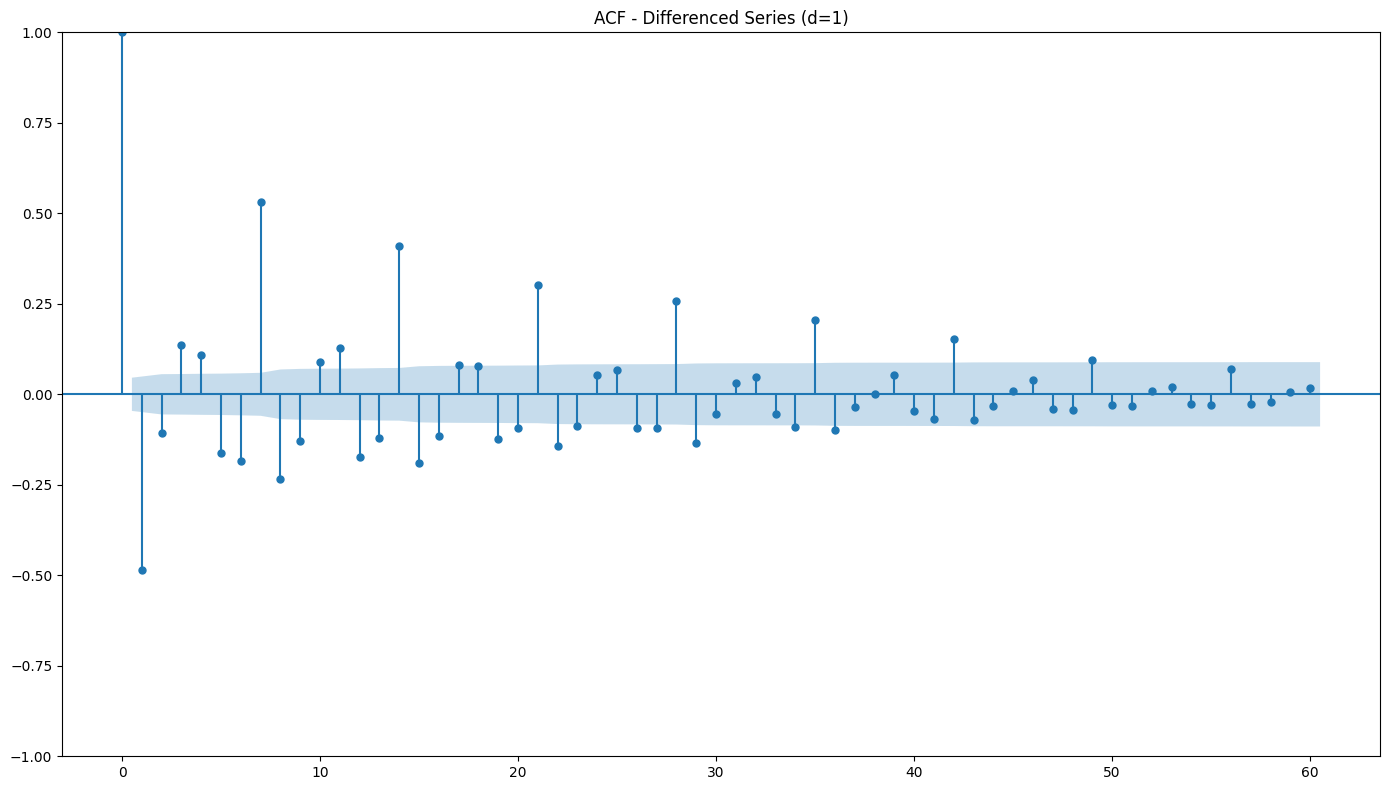

<Figure size 1400x500 with 0 Axes>

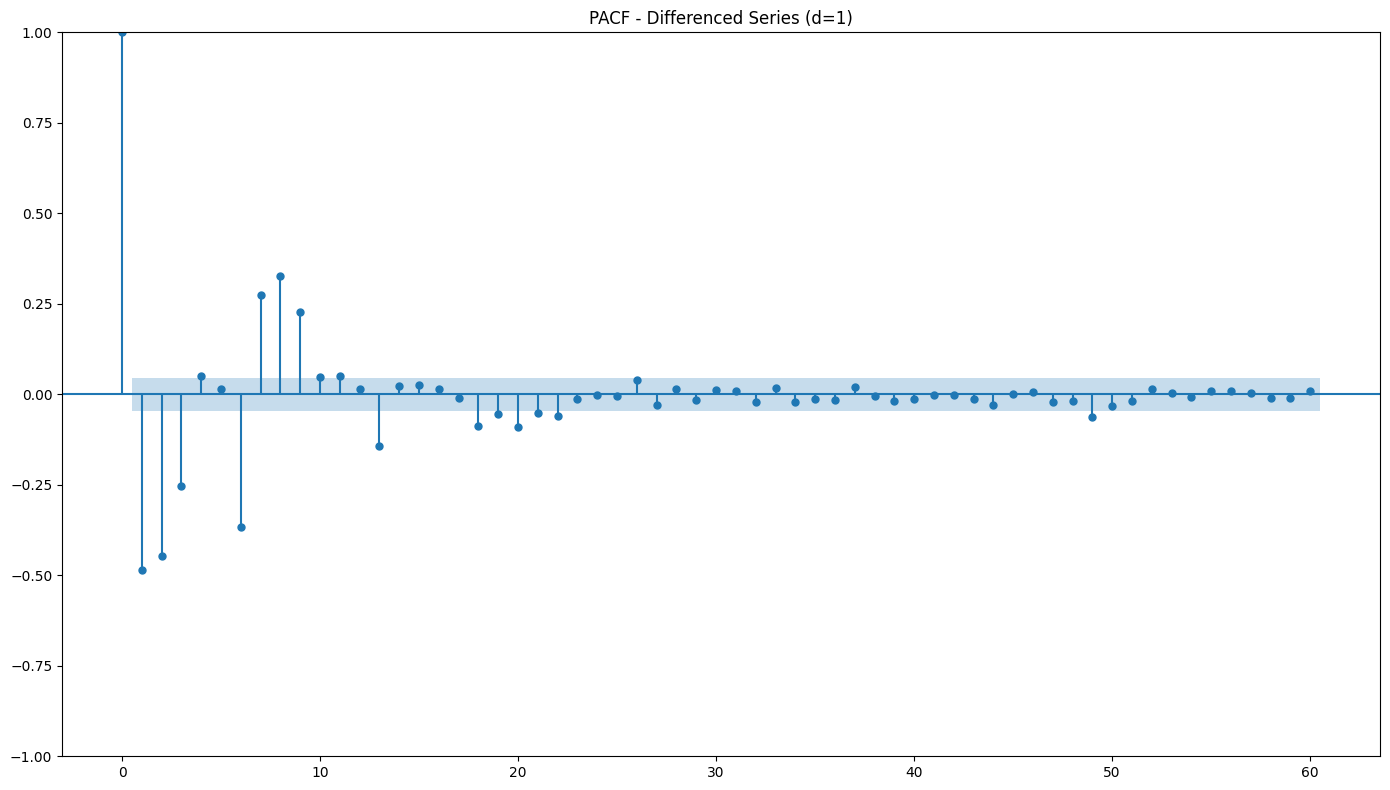

In [93]:
plt.figure(figsize=(14,5))
plot_acf(ts_diff, lags=60)
plt.title("ACF - Differenced Series (d=1)")
plt.tight_layout()
plt.show()

# ---- PACF ----
plt.figure(figsize=(14,5))
plot_pacf(ts_diff, lags=60)
plt.title("PACF - Differenced Series (d=1)")
plt.tight_layout()
plt.show()

Order Sarima (3,1,1,7)

# Model Sarima

In [94]:
model1 = sm.tsa.statespace.SARIMAX(
    data1['Total'],
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result1 = model1.fit()
print(result1.summary())


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 1826
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -10539.222
Date:                Tue, 02 Dec 2025   AIC                          21084.443
Time:                        16:49:10   BIC                          21100.968
Sample:                             0   HQIC                         21090.539
                               - 1826                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1705      0.017    -10.127      0.000      -0.203      -0.137
ma.L1         -0.6091      0.013    -46.358      0.000      -0.635      -0.583
sigma2      6152.0680     57.475    107.039      0.0

In [95]:
import statsmodels.api as sm

model1 = sm.tsa.statespace.SARIMAX(
    data1['Total'],
    order=(1,0,1),
    seasonal_order=(3,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result1 = model1.fit()
print(result1.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             Total   No. Observations:                 1826
Model:             SARIMAX(1, 0, 1)x(3, 1, 1, 7)   Log Likelihood               -9962.294
Date:                           Tue, 02 Dec 2025   AIC                          19938.589
Time:                                   16:49:16   BIC                          19977.046
Sample:                                        0   HQIC                         19952.786
                                          - 1826                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9770      0.002    428.020      0.000       0.973       0.981
ma.L1         -0.6795      0.009    -78.500

In [96]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
aic_arima = ARIMA(ts, order=(1,0,1)).fit().aic
aic_sarima = SARIMAX(ts, order=(1,0,1), seasonal_order=(3,1,1,7)).fit().aic

print("AIC ARIMA :", aic_arima)
print("AIC SARIMA:", aic_sarima)


c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was prov

AIC ARIMA : 21147.84578693389
AIC SARIMA: 20287.013427386504


In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

p = [0,1,2,3]
d = [0,1]
q = [0,1]
P = [0,1,2,3]
D = [0,1]
Q = [0,1]
s = 7

best = (None, 1e9)
for order in itertools.product(p,d,q):
    for sorder in itertools.product(P,D,Q):
        try:
            mod = SARIMAX(ts, order=order, seasonal_order=(sorder[0], sorder[1], sorder[2], s),
                           enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            if res.aic < best[1]:
                best = ((order, sorder), res.aic)
        except:
            continue

print("Best:", best)


c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

Best: (((3, 0, 1), (3, 1, 1)), 19767.37579003164)


# Model Final Sarima

In [98]:
import statsmodels.api as sm

model1 = sm.tsa.statespace.SARIMAX(
    data1['Total'],
    order=(3,0,1),
    seasonal_order=(3,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result1 = model1.fit()
print(result1.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             Total   No. Observations:                 1826
Model:             SARIMAX(3, 0, 1)x(3, 1, 1, 7)   Log Likelihood               -9874.688
Date:                           Tue, 02 Dec 2025   AIC                          19767.376
Time:                                   16:56:46   BIC                          19816.811
Sample:                                        0   HQIC                         19785.627
                                          - 1826                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4580      0.023     19.731      0.000       0.413       0.504
ar.L2          0.2562      0.012     21.758

In [99]:
aic_arima = ARIMA(ts, order=(3,0,1)).fit().aic
aic_sarima = SARIMAX(ts, order=(3,0,1), seasonal_order=(3,1,1,7)).fit().aic

print("AIC ARIMA :", aic_arima)
print("AIC SARIMA:", aic_sarima)

c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

AIC ARIMA : 21017.138129611085
AIC SARIMA: 20174.666032541078


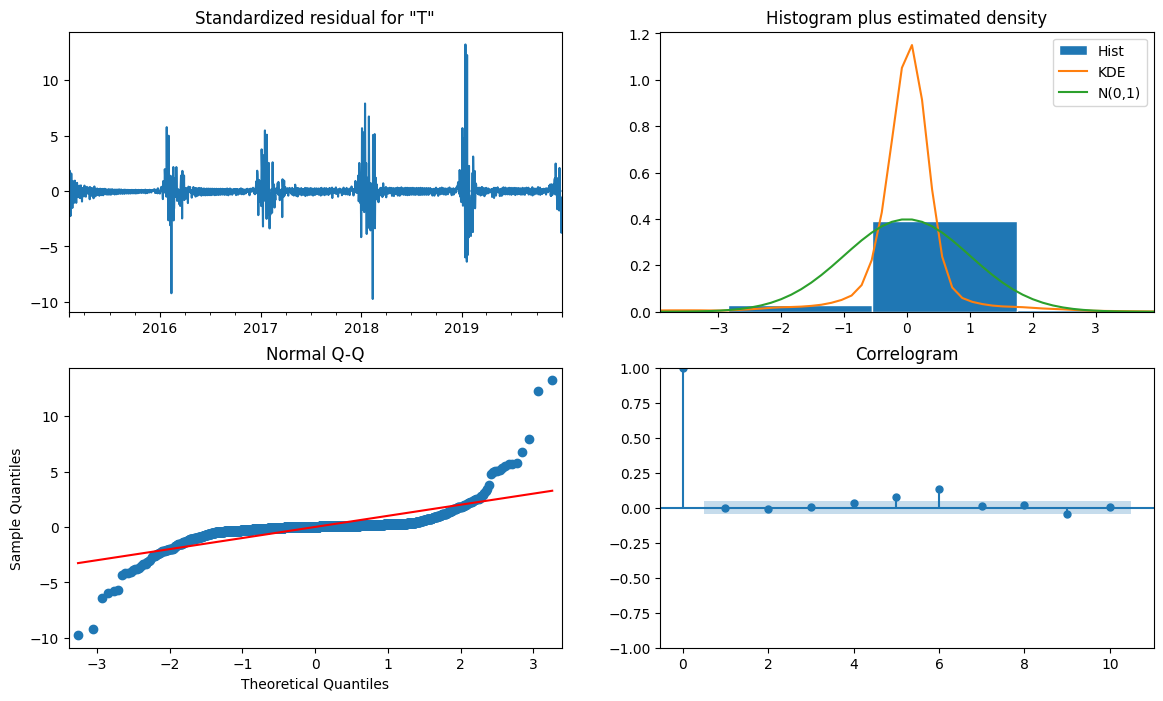

In [100]:
res.plot_diagnostics(figsize=(14,8))
plt.show()


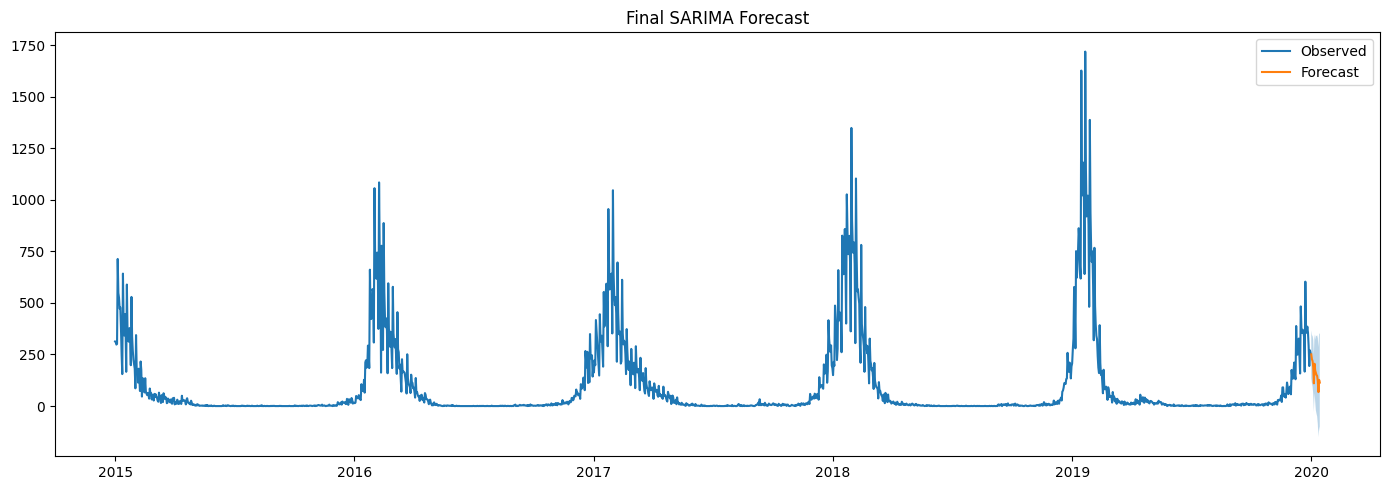

In [101]:
steps = 14

forecast = res.get_forecast(steps=steps)
mean = forecast.predicted_mean
ci = forecast.conf_int()
plt.figure(figsize=(14,5))
plt.plot(ts, label='Observed')
plt.plot(mean, label='Forecast')
plt.fill_between(
    ci.index,
    ci.iloc[:, 0],
    ci.iloc[:, 1],
    alpha=0.3
)

plt.legend()
plt.title('Final SARIMA Forecast')
plt.tight_layout()
plt.show()


In [102]:
print(res.aic)

19776.782981428463


c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MADEYZ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE  : 56.499
RMSE : 77.972
MAPE : 20.62 %


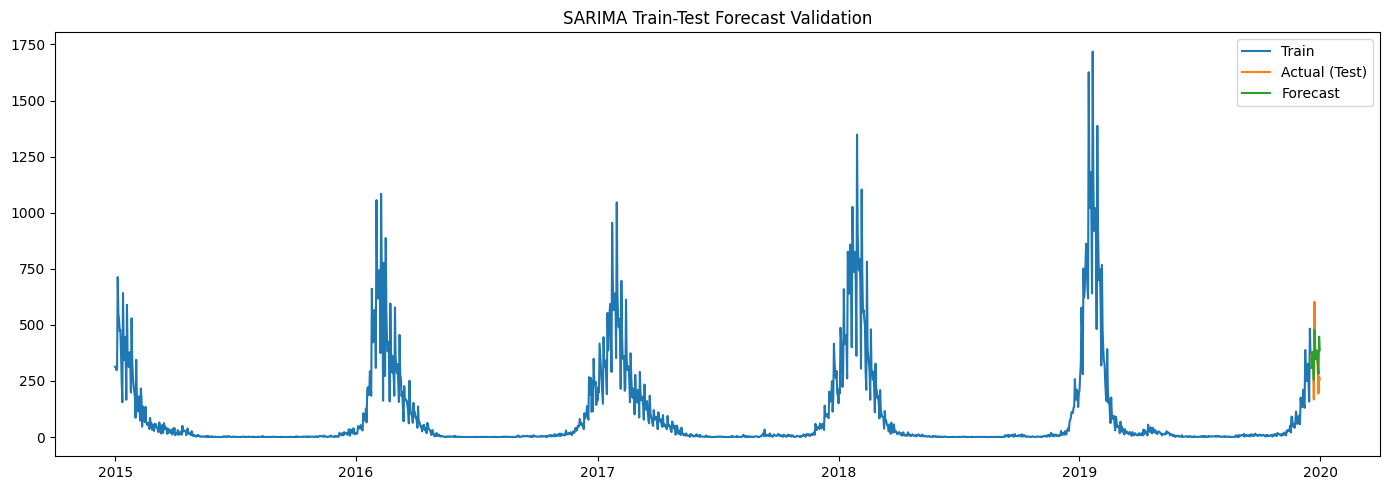

In [105]:
import numpy as np

test_size = 14                       # sesuai horizon forecast
train = ts.iloc[:-test_size]
test  = ts.iloc[-test_size:]
model = SARIMAX(
    train,
    order=(3,0,1),
    seasonal_order=(3,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit()
forecast = res.get_forecast(steps=test_size)
pred = forecast.predicted_mean

mae  = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MAPE : {mape:.2f} %")

plt.figure(figsize=(14,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual (Test)')
plt.plot(pred.index, pred, label='Forecast')

plt.legend()
plt.title('SARIMA Train-Test Forecast Validation')
plt.tight_layout()
plt.show()
